In [314]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.modeling import models, fitting
plt.rcParams.update({'font.size': 18})

In [149]:
#My rewrite of IRAF method IMCOMBINE in Python-3
#Takes multiple images, lets work from text file instead of data
#Can do avg, med and sig clipping based on passed params
def imcombine(infile,average=False,median=False,sig=False,signum=3,expweight=False):
    #text file opener
    files=open(infile)
    #combined data(for avg) and an intialize boolean
    cmb_data=[]; init=False; cnt=0
    
    
    for i in files:
        cnt += 1 #increment counter
        hdul = fits.open(('Spectra_zbt/'+str.strip(i)))
        data = hdul[0].data
        
        
        cmb_data.append(data)
       
    #determine row and col length of images
    y=len(cmb_data[0])
    x=len(cmb_data[0][0])
    cmb_data=np.asarray(cmb_data)
    
    temp=cmb_data
    #If sig filter is true
    out_data=[]
    if(sig):
        for i in range(cnt):
            avg=np.average(cmb_data[i])
            std=np.std(cmb_data[i])
            
            #If value > avg+-3sig set equal to image average.
            cmb_data[i][cmb_data[i] > avg+signum*std] = avg
            cmb_data[i][cmb_data[i] < avg-signum*std] = avg
    
            
    #If average is true, overrides median if both are true
    if(average):
        #weighting by sqrt(avg #photons in original image)
        if(expweight==True):
            avg=cmb_data[0]*np.sqrt(np.average(cmb_data[0]))
            for i in cmb_data[1:]:
                avg+=i*np.sqrt(np.average(i))
            avg=avg/cnt
            return(avg)
        else:
            avg=cmb_data[0]
            for i in cmb_data[1:]:
                avg+=i
            avg=avg/cnt
            return(avg)
    
    #If median is true
    #much much faster, one line vectored median from Matt Messersmith on S/O
    #https://stackoverflow.com/questions/52990299/faster-median-in-very-large-numpy-arrays
    if(median):
        median = np.zeros((1,y,x))
        median[0, :, :] = np.median(cmb_data,axis=0)

        return(median[0])        

In [150]:
#Rewrite of IRAF method colbias in Python 3


def colbias(data,plot=False):
    #Remove Overscan
    data_cp=[]
    bias_avg=[]
    for i in range(len(data)):
        #Calculate bias
        bias=np.average(data[i][2120:2190])
        bias_avg.append(bias)
    
        #remove bias and clip images
        if(i>755 and i<1020):
            data_cp.append(data[i][55:2096]-bias)
    #rewrite into np_array
    data_cb=np.asarray(data_cp)
    #Plot bias vals
    #print(bias_avg)
    if(plot):
        plt.figure()
        plt.plot(bias_avg)
        plt.show()
    #Return output array
    return data_cb

In [13]:
#Rewrite of IRAF method imstat in Python 3
def imstat(data,x1=0,x2=100000,y1=0,y2=100000):
    #If x2,y2 not set, set them to the max of the passed data
    if(x2==100000):
        x2=len(data[0])
        y2=len(data)
    #print(x1,x2,y1,y2)
    #clipped data, if applicable
    data_cp=[]
    #clip data to given range
    for i in range(len(data)):
        #clip in y
        if(i>y1 and i<y2):
                #clip in x
                data_cp.append(data[i][x1:x2])
    #Thank you numpy
    return([np.average(data_cp),np.std(data_cp),np.max(data_cp),np.min(data_cp)])

In [26]:
# In logfile trim is [55:2096,755:1020]
#and overscan is [2120:2190] I'll adopt these values
all_images=open('Spectra/allfiles.txt')

for i in all_images:
    hdul = fits.open(('Spectra/'+str.strip(i)))
    #data = hdul[0].data
    
    hdul[0].data=colbias(hdul[0].data)
    hdul.writeto(fileobj=('Spectra_zt/'+i.replace('fits', 'zf.fits')[0:-1]),overwrite=True)    

In [32]:
#Lets open the biases and call imstat to get some idea what they look like
bias=open('Spectra_zt/bias.txt')
print('\tAverage\t\tSt-Dev\t\t\tMax\t\tMin')
for i in bias:
    hdul = fits.open(('Spectra_zt/'+str.strip(i)))
    data = hdul[0].data
    print(imstat(data))

	Average		St-Dev			Max		Min
[3.7319489839070386, 4.431817602351867, 26.971428571428532, -13.085714285714289]
[3.7675350054996946, 4.43304859605288, 26.399999999999977, -13.157142857142844]
[3.7503956240896517, 4.431230110141769, 26.85714285714289, -12.742857142857133]
[3.765001739197084, 4.444363059102282, 264.61428571428576, -14.914285714285711]
[3.768749356284167, 4.428160761934507, 29.671428571428578, -13.571428571428555]
[3.7563597261037365, 4.501104573625307, 534.4857142857143, -13.457142857142912]
[3.7946208111231985, 4.426494531361169, 28.81428571428569, -12.685714285714312]
[3.768566521028317, 4.42771466219914, 27.385714285714243, -13.799999999999955]
[3.7691916472764593, 4.426409874123815, 25.471428571428532, -12.64285714285711]
[3.7517756976016625, 4.422761681061757, 27.485714285714266, -13.14285714285711]


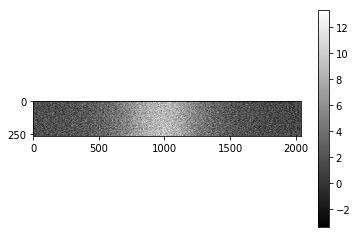

	Average		St-Dev			Max		Min
[0.016024012932649438, 3.4814422797537734, 19.200203949447637, -16.473082588854826]
[0.051610034525305805, 3.4812730604322435, 20.353286538302445, -18.213856318840445]
[0.03447065311526193, 3.470773935249923, 19.089206860019026, -16.411507757104935]
[0.049076768222694946, 3.538104679840636, 257.26650620610815, -18.86920807960617]
[0.05282438530977727, 3.4948328308607897, 20.208856170368925, -17.495429543916796]
[0.04043475512934728, 3.5898252692206305, 532.6087302029181, -16.532698368510502]
[0.07869584014880829, 3.4837079840489715, 22.97420652860938, -16.953571759980925]
[0.05264155005392739, 3.457144196221964, 18.216215154272447, -17.193784845727542]
[0.05326667630206989, 3.469210358993306, 19.363088729211338, -19.1669112707886]
[0.0358507266272721, 3.478349592420943, 20.194832243128392, -17.18802489972875]


In [41]:
#Pretty consistent except for one hit of 534, lets combine them all into a master-bias using avg and sigma rejection

m_bias=imcombine('Spectra_zt/bias.txt',average=True,sig=True)

plt.figure(figsize=(20,5))
plt.imshow(m_bias,cmap='gray')
plt.colorbar()
plt.show()

#Definitely a pattern as was suggested we would fine so lets subtract this from all images

infiles=open('Spectra_zt/infiles.txt')

for i in infiles:
    hdul = fits.open(('Spectra_zt/'+str.strip(i)))
    #data = hdul[0].data
    hdul[0].data=(hdul[0].data)-m_bias
    hdul.writeto(fileobj=('Spectra_zbt/'+i.replace('zf.fits', 'zbt.fits')[0:-1]),overwrite=True)
#lets open the bias_subtracted biases again and see if the average is close to zero now
bias=open('Spectra_zbt/bias.txt')
print('\tAverage\t\tSt-Dev\t\t\tMax\t\tMin')
for i in bias:
    hdul = fits.open(('Spectra_zbt/'+str.strip(i)))
    data = hdul[0].data
    print(imstat(data))

In [44]:
#Now lets go ahead and open our dome flats to make a master flat

d_flat=open('Spectra_zbt/dflats.txt')
print('   Filename\t\t\t\tAvg\t\tSt-Dev\t\tMax\t\tMin')

for i in d_flat:
    hdul = fits.open(('Spectra_zbt/'+str.strip(i)))
    print(str.strip(i),', exptime=',hdul[0].header['EXPTIME'],imstat(hdul[0].data))

   Filename				Avg		St-Dev		Max		Min
t001.zbt.fits , exptime= 150 [5970.624154805873, 2410.4382516530773, 9423.528571428571, 395.8357142857143]
t002.zbt.fits , exptime= 150 [5945.3128580089, 2399.0419827349133, 9541.788571428571, 402.18571428571437]
t003.zbt.fits , exptime= 150 [5951.295511840019, 2404.349105788415, 9547.888571428572, 402.1757142857143]
t004.zbt.fits , exptime= 150 [5899.2728973277935, 2386.7326175726157, 10675.864285714286, 397.86428571428576]
t005.zbt.fits , exptime= 150 [5974.873768150559, 2417.5472357579615, 9650.368571428571, 401.8714285714285]
t006.zbt.fits , exptime= 150 [5900.94050929975, 2390.282486755906, 10184.094285714285, 390.93571428571437]
t007.zbt.fits , exptime= 150 [5940.136516252282, 2405.7892756241863, 9591.257142857143, 402.32]


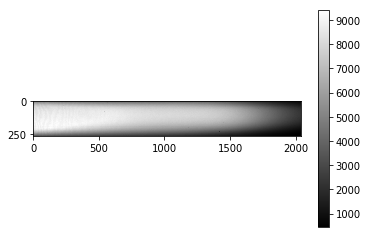

In [48]:
#All flats are pretty much the same, so lets do a master flat with the average and sigma rejection

m_flat=imcombine('Spectra_zbt/dflats.txt',average=True,sig=True)

plt.figure(figsize=(20,5))
plt.imshow(m_flat,cmap='gray')
plt.colorbar()
plt.show()

In [76]:
#Writeup of response func
def Response(m_flat,degree):
    rm_flat=[]
    degree=degree
    poly_fit=models.Polynomial1D(degree)
    fit = fitting.LevMarLSQFitter()
    for i in m_flat:
        x=range(len(i))
        fitted_line = fit(poly_fit, x, i)
        rm_flat.append(i/fitted_line(x))
        #print(i)
        #print(poly_fit)
    return np.asarray(rm_flat)

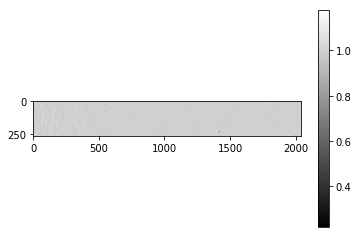

In [77]:
rm_flat=Response(m_flat,15)
plt.figure(figsize=(20,5))
plt.imshow(rm_flat,cmap='gray')
plt.colorbar()
plt.show()

In [80]:
#Now lets divide all the images by the response calibrated master flat
imgs=open('Spectra_zbt/infiles.txt')

for i in imgs:
    hdul = fits.open(('Spectra_zbt/'+str.strip(i)))
    #data = hdul[0].data
    hdul[0].data=(hdul[0].data)/rm_flat
    hdul.writeto(fileobj=('Spectra_zbmt/'+i.replace('zbt.fits', 'zbmt.fits')[0:-1]),overwrite=True)

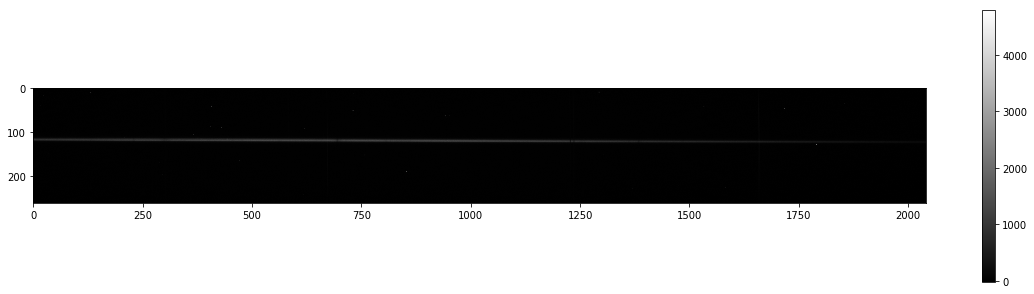

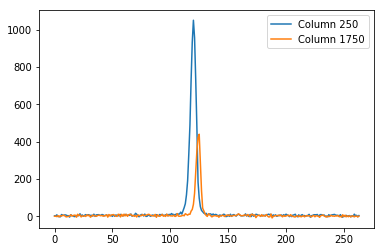

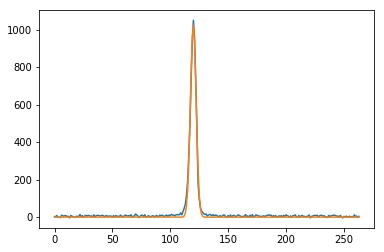

2.478442164282177
5 sigma = 12.392210821410885


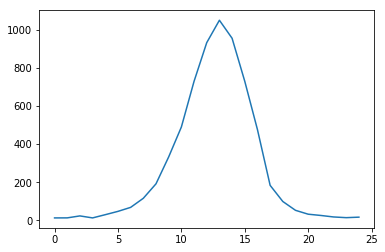

6646.675236687344
446.04814031831705


In [141]:
#Ok lets open up one of the fully reduced 2d spectra and plot it
hdul = fits.open('Spectra_zbmt/t026.zbmt.fits')
data=hdul[0].data
#lets plot the 2d spec
plt.figure(figsize=(20,5))
plt.imshow(data,cmap='gray')
plt.colorbar()
plt.show()
#lets plot two columns so we can see the shift in center location across the chip
plt.plot(data[:,250],label='Column 250')
plt.plot(data[:,1750],label='Column 1750')
plt.legend()
plt.show()

y=data[:,250]
x=range(len(y))
gauss_model=models.Gaussian1D(mean=len(x)/2)
fitter = fitting.LevMarLSQFitter()
gauss_fit = fitter(gauss_fit, x, y)

plt.plot(y)
plt.plot(fitted_line(x))
plt.show()
mean=gauss_fit.mean.value
stddev=gauss_fit.stddev.value
print(gauss_fit.stddev.value)
print('5 sigma =',5*gauss_fit.stddev.value)

plt.plot(y[int(np.round(mean-5*stddev)):int(np.round(mean+5*stddev))])
plt.show()
ap_sum=np.sum(y[int(np.round(mean-5*stddev)):int(np.round(mean+5*stddev))])

bg_sum=np.sum(y[int(np.round(50+mean-5*stddev)):int(np.round(100+mean+5*stddev))])

print(ap_sum)
print(bg_sum)

In [163]:
#turn 2d spectra into 1d spectra by fitting gaussians at every column
def spec_2dto1d(data,sigma,bg_sub=True):
    out_1d=[]
    fitter = fitting.LevMarLSQFitter()
    for i in range(len(data[0])):
        #determine column range and values
        y=data[:,i]
        x=range(len(y))
        #make gauss model
        gauss_model=models.Gaussian1D(mean=len(x)/2)
        gauss_fit = fitter(gauss_model, x, y)
        #extract model parameters
        mean=gauss_fit.mean.value
        stddev=gauss_fit.stddev.value
        #determine sum in aperture and background
        ap_sum=np.sum(y[int(np.round(mean-sigma*stddev)):int(np.round(mean+sigma*stddev))])
        bg_sum=np.sum(y[int(np.round(50+mean-sigma*stddev)):int(np.round(100+mean+sigma*stddev))])
        #add value to output array
        if(bg_sub):
            out_1d.append(ap_sum-bg_sum)
        else:
            out_1d.append(ap_sum)
    return(np.asarray(out_1d))

In [176]:
#open a spectra for MT720
hdul = fits.open('Spectra_zbmt/t034.zbmt.fits')
MT299_data=hdul[0].data
#lets turn this into a 1d spectrum
MT299_data_1d=spec_2dto1d(MT299_data,5)

#open a spectra for MT720
hdul = fits.open('Spectra_zbmt/t038.zbmt.fits')
MT138_data=hdul[0].data
#lets turn this into a 1d spectrum
MT138_data_1d=spec_2dto1d(MT138_data,5)

#open a spectra for MT720
hdul = fits.open('Spectra_zbmt/t040.zbmt.fits')
MT145_data=hdul[0].data
#lets turn this into a 1d spectrum
MT145_data_1d=spec_2dto1d(MT145_data,5)

#lets do it for a cuar spectra aswell
hdul = fits.open('Spectra_zbmt/t039.zbmt.fits')
cuar_data=hdul[0].data
cuar_data_1d=spec_2dto1d(cuar_data,5,bg_sub=False)

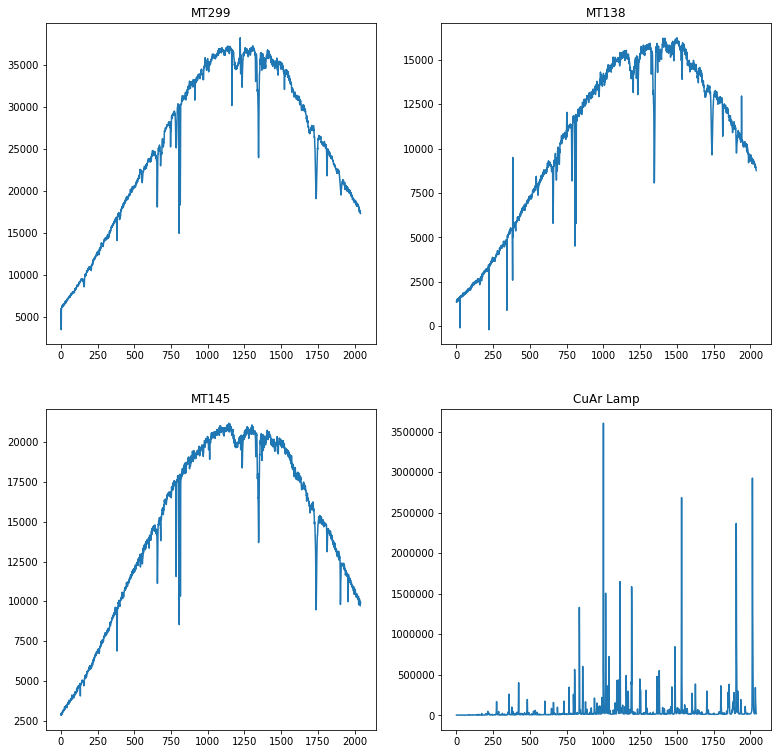

In [183]:
#flip around hee
MT299_data_1d=np.flip(MT299_data_1d)
MT299_data_1d=np.flip(MT299_data_1d)
MT138_data_1d=np.flip(MT138_data_1d)
MT145_data_1d=np.flip(MT145_data_1d)
cuar_data_1d=np.flip(cuar_data_1d)

plt.figure(figsize=(13,13))
plt.subplot(2,2,1)
plt.plot(MT299_data_1d)
plt.title('MT299')

plt.subplot(2,2,2)
plt.plot(MT138_data_1d)
plt.title('MT138')

plt.subplot(2,2,3)
plt.plot(MT145_data_1d)
plt.title('MT145')

plt.subplot(2,2,4)
plt.plot(cuar_data_1d)
plt.title('CuAr Lamp')
plt.show()

/Users/napolilg/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/napolilg/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


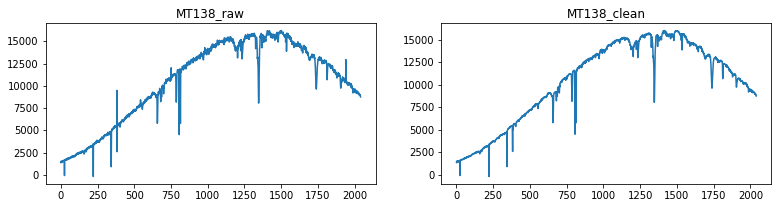

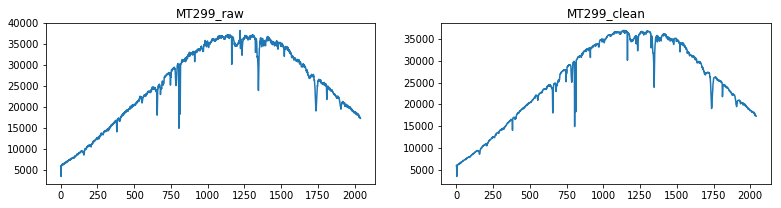

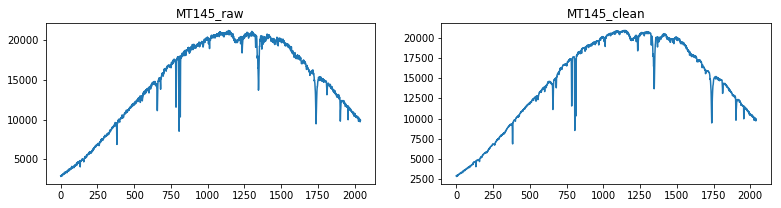

In [215]:
#quick function to interpolate cosmic rays
def quick_clean(data,threshold):
    temp_data=[]
    for i in range(len(data)):
        if(data[i]>threshold*np.median(data[i-10:i+10])):
            temp_data.append(np.median(data[i-10:i+10]))
        else:
            temp_data.append(data[i])
    return(temp_data)
            
MT138_clean=quick_clean(MT138_data_1d,1)
MT299_clean=quick_clean(MT299_data_1d,1)
MT145_clean=quick_clean(MT145_data_1d,1)
    
plt.figure(figsize=(13,6.5))    
plt.subplot(2,2,1)
plt.title('MT138_raw')
plt.plot(MT138_data_1d)

plt.subplot(2,2,2)
plt.title('MT138_clean')
plt.plot(MT138_clean)
plt.show()

plt.figure(figsize=(13,6.5))    
plt.subplot(2,2,1)
plt.title('MT299_raw')
plt.plot(MT299_data_1d)

plt.subplot(2,2,2)
plt.plot(MT299_clean)
plt.title('MT299_clean')
plt.show()

plt.figure(figsize=(13,6.5))    
plt.subplot(2,2,1)
plt.title('MT145_raw')
plt.plot(MT145_data_1d)

plt.subplot(2,2,2)
plt.title('MT145_clean')
plt.plot(MT145_clean)
plt.show()


In [211]:
#Write out 1D-spectra

hdu = fits.PrimaryHDU(MT299_clean)
hdu.writeto('t034_1d_spec.fits',overwrite=True)

hdu = fits.PrimaryHDU(MT138_clean)
hdu.writeto('t038_1d_spec.fits',overwrite=True)

hdu = fits.PrimaryHDU(MT145_clean)
hdu.writeto('t040_1d_spec.fits',overwrite=True)

hdu = fits.PrimaryHDU(cuar_data_1d)
hdu.writeto('t039_1d_spec.fits',overwrite=True)

In [270]:
#Identify and dispcor run in IRAF
#lets open the results

#set x spacing from dispcor
x_spc=np.linspace(5294.665,6771.769,2041)

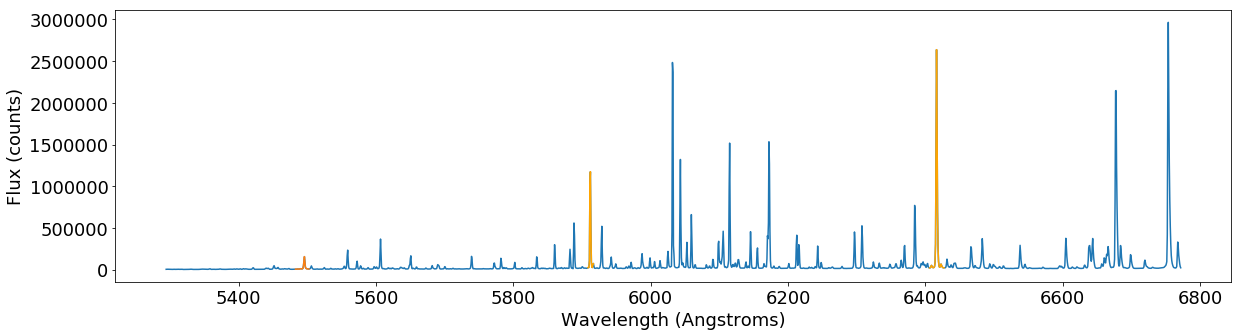

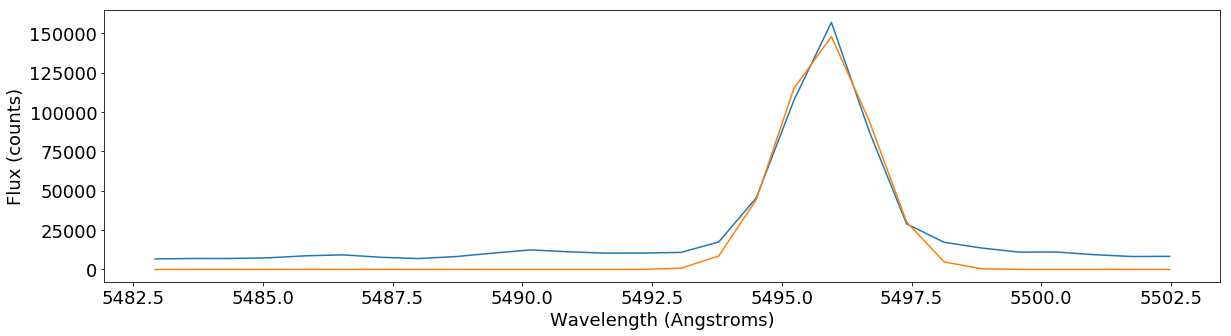

FWHM = 2.0404155824530052


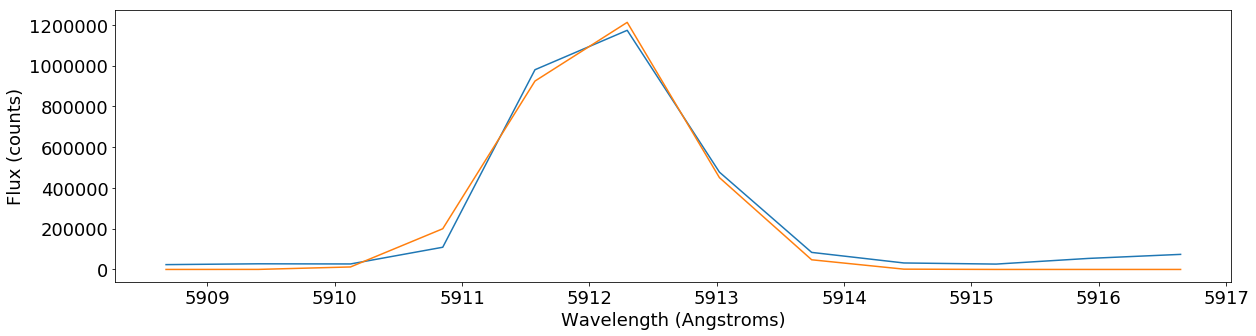

FWHM = 1.5183092813603842


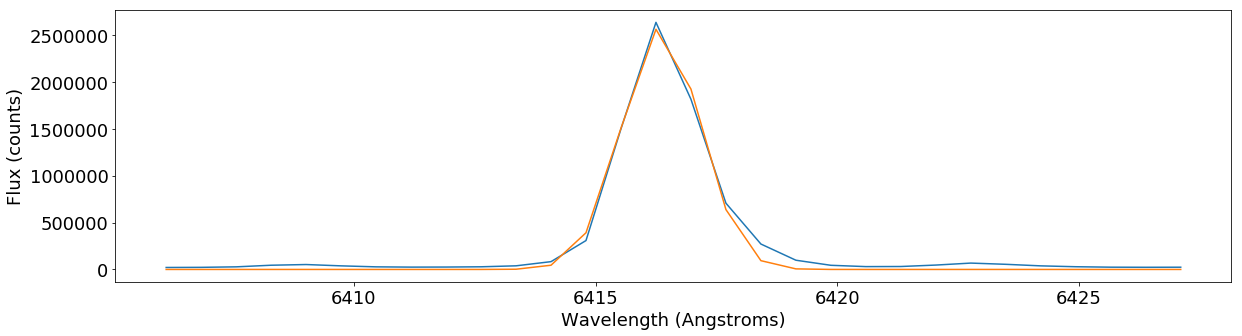

FWHM = 1.8865268577885244


In [315]:
#Problem 11 looking at lines in CuAr spectra
hdul = fits.open('Spectra_Id/CuAr_w.fits')
CuAr_w=hdul[0].data

plt.figure(figsize=(20,5))
plt.plot(x_spc,CuAr_w)
plt.plot(x_spc[260:288],CuAr_w[260:288])
plt.plot(x_spc[848:860],CuAr_w[848:860],c='orange')
plt.plot(x_spc[1535:1565],CuAr_w[1535:1565],c='orange')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (counts)')
plt.show()

gauss_model=models.Gaussian1D(mean=5495,amplitude=160000)
gauss_fit = fitter(gauss_model, x_spc[260:288], CuAr_w[260:288])
plt.figure(figsize=(20,5))
plt.plot(x_spc[260:288],CuAr_w[260:288])
plt.plot(x_spc[260:288],gauss_fit(x_spc[260:288]))
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (counts)')
plt.show()
print('FWHM =',gauss_fit.parameters[2]*2.355)


gauss_model=models.Gaussian1D(mean=5912,amplitude=120000)
gauss_fit = fitter(gauss_model, x_spc[848:860], CuAr_w[848:860])
plt.figure(figsize=(20,5))
plt.plot(x_spc[848:860],CuAr_w[848:860])
plt.plot(x_spc[848:860],gauss_fit(x_spc[848:860]))
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (counts)')

plt.show()
print('FWHM =',gauss_fit.parameters[2]*2.355)

gauss_model=models.Gaussian1D(mean=6416,amplitude=250000)
gauss_fit = fitter(gauss_model, x_spc[1535:1565], CuAr_w[1535:1565])
plt.figure(figsize=(20,5))
plt.plot(x_spc[1535:1565],CuAr_w[1535:1565])
plt.plot(x_spc[1535:1565],gauss_fit(x_spc[1535:1565]))
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (counts)')
plt.show()
print('FWHM =',gauss_fit.parameters[2]*2.355)

#FWHM is larger on edges of chip but very inconclusive with n=3
#FWHM values are 1.5 to 2 angstroms

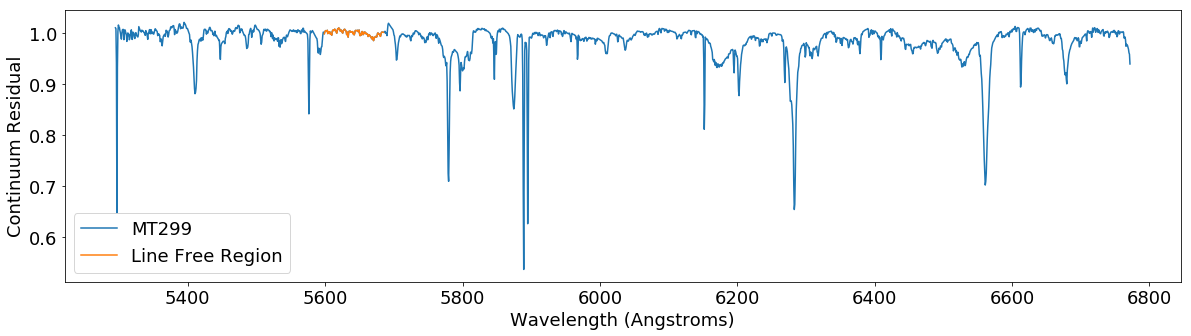

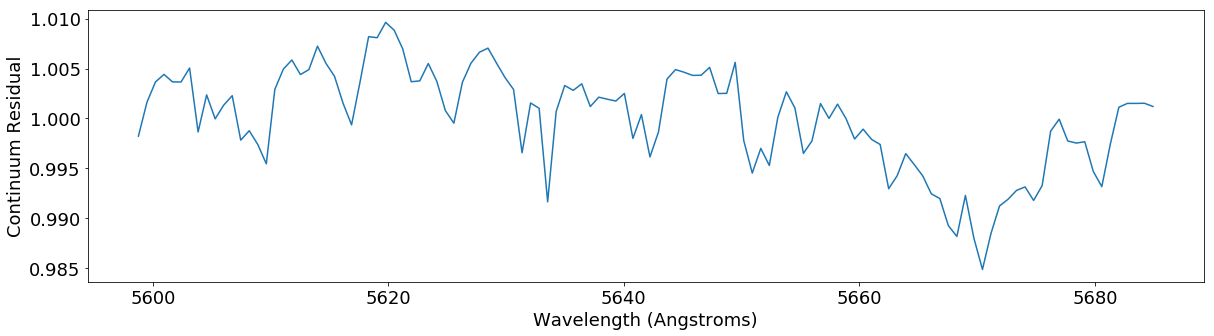

RMS = 1.0000083052973605


In [324]:
#Problem 13 looking at rms of stellar continuum

hdul = fits.open('Spectra_Id/MT299_wc.fits')
MT299_wc=hdul[0].data

plt.figure(figsize=(20,5))
plt.plot(x_spc,MT299_wc,label="MT299")
plt.plot(x_spc[420:540],MT299_wc[420:540],label="Line Free Region")
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Continuum Residual')
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(x_spc[420:540],MT299_wc[420:540])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Continuum Residual')
plt.show()
rms = np.sqrt(np.mean(MT299_wc[420:540]**2))
print('RMS =',rms)

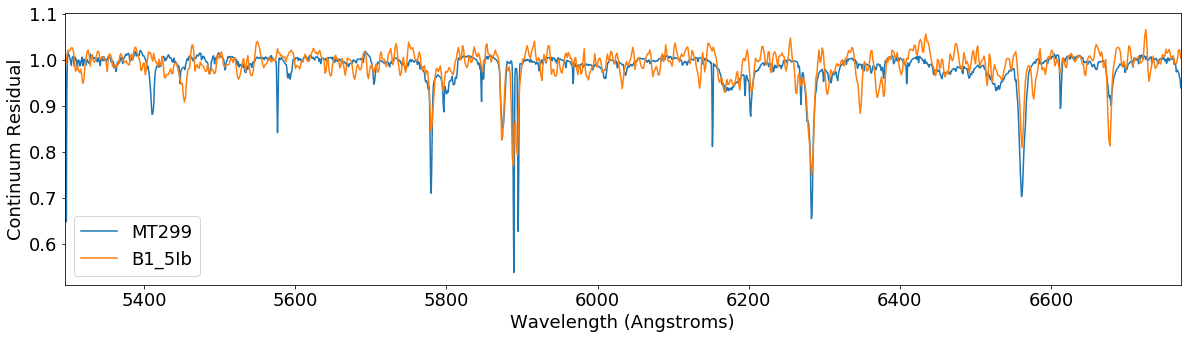

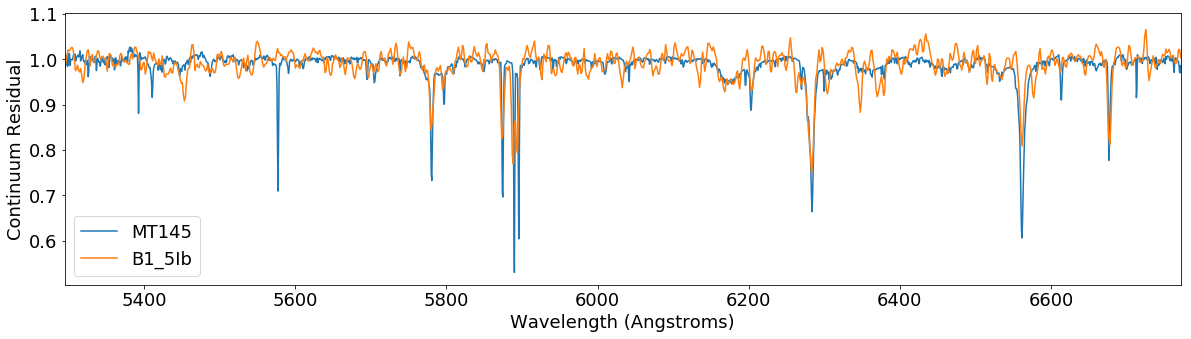

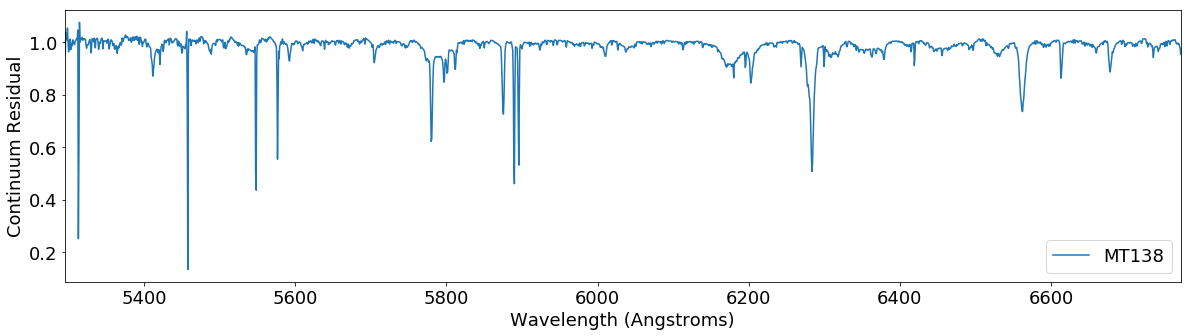

In [325]:
#Problem 14
#overplotting Jacoby Spectra
#per http://articles.adsabs.harvard.edu/pdf/1984ApJS...56..257J
#the spectra cover wavelength range 3510-7427 angstroms
#open jacoby spectra
temps=open('Spectra_Id/JacobySpectra/infiles.txt')

#open the 3 stellar spectra
hdul = fits.open('Spectra_Id/MT299_wc.fits')
MT299_wc=hdul[0].data

hdul = fits.open('Spectra_Id/MT145_wc.fits')
MT145_wc=hdul[0].data

hdul = fits.open('Spectra_Id/MT138_wc.fits')
MT138_wc=hdul[0].data

#open best fits for stellar spectra
hdul = fits.open('Spectra_Id/JacobySpectra/B1.5Ib-n.fits')
B1_5Ib=hdul[0].data

#plots
plt.figure(figsize=(20,5))
plt.plot(x_spc,MT299_wc,label='MT299')
plt.xlim(5294.665,6771.769)
plt.plot(np.linspace(3510,7427,2799),B1_5Ib,label='B1_5Ib')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Continuum Residual')
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(x_spc,MT145_wc,label='MT145')
plt.xlim(5294.665,6771.769)
plt.plot(np.linspace(3510,7427,2799),B1_5Ib,label='B1_5Ib')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Continuum Residual')
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(x_spc,MT138_wc,label='MT138')
plt.xlim(5294.665,6771.769)
#plt.plot(np.linspace(3510,7427,2799),B1_5Ib,label='B1_5Ib')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Continuum Residual')
plt.legend()
plt.show()
#This loop displays a stellar model overlaid with every Jacoby Spectra for visual ID
'''
for i in temps:
    print(i)
    hdul = fits.open('Spectra_Id/JacobySpectra/'+i.strip())
    template=hdul[0].data
    plt.xlim(5294.665,6771.769)
    plt.plot(x_spc,MT138_wc)
    plt.plot(np.linspace(3510,7427,2799),template)
    #plt.plot(np.linspace(3510,7427,2799),template)
    plt.show()
''';
#For both MT299 and MT145 I find the best fit is a B-type star of luminosity class 1.5
#For MT138 I was unable to find a best fit, I suspect the features between 5400 and 5600 are poorly
#subtracted sky lines. Discarding those I think it would be best fit by a similar spectra to MT299 and MT145. 
#Notably all 3 spectra have a feature just short of 5600 that is in none of the jacoby spectra.